In [18]:
import os, shutil

import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv(os.path.join(".DATA", "source.csv"))

df.sample(15)

,context,video_id,out_of_distribution,zoom,from_internet,image_path,image_class
734,FIELD,21,0,0,0,Healthy Leaves/image366.jpg,Healthy Leaves
2963,FIELD,378,0,0,0,Diseases/Brown Spot/image1264.jpg,Brown Spot
5697,LAB,261,0,0,0,Diseases/Yellow Leaf/Yellow Leaf621.jpg,Yellow Leaf
1962,LAB,361,0,0,0,Diseases/Brown Spot/image792.jpg,Brown Spot
504,FIELD,8,0,0,0,Healthy Leaves/image141.jpg,Healthy Leaves
3275,LAB,340,0,0,0,Diseases/Brown Spot/image374.jpg,Brown Spot
4311,FIELD,146,0,0,0,Diseases/Sett Rot/Sett Rot018.jpg,Sett Rot
5446,LAB,198,0,0,0,Diseases/Viral Disease/Viral Disease450.jpg,Viral Disease
488,FIELD,6,0,0,0,Healthy Leaves/image103.jpg,Healthy Leaves
1109,LAB,135,0,0,0,Diseases/Banded Chlorosis/image277.jpg,Banded Chlorosis


In [20]:
df = df[(df["out_of_distribution"] == 0)]

In [21]:
from sklearn.model_selection import train_test_split

In [ ]:
video_class = (
    df.groupby("video_id")["image_class"]
    .agg(lambda x: x.mode()[0])
    .reset_index()
)

train_videos, temp_videos = train_test_split(
    video_class,
    test_size=0.3,
    stratify=video_class["image_class"],
    random_state=42,
)

val_videos, test_videos = train_test_split(
    temp_videos,
    test_size=0.5,
    stratify=temp_videos["image_class"],
    random_state=42,
)

train_df = df[df["video_id"].isin(train_videos["video_id"])]
val_df = df[df["video_id"].isin(val_videos["video_id"])]
test_df = df[df["video_id"].isin(test_videos["video_id"])]

In [23]:
def plot_images_distribution(df: pd.DataFrame, include_context: bool = False, title: str ="Class Distribution"):
    dist_full = df["image_class"].value_counts().sort_index()
    dist_videos = df.groupby("image_class")["video_id"].nunique()
    dist_context = df["context"].value_counts().sort_index()

    n_plots = 3 if include_context else 2

    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), sharey=False)

    fig.suptitle(title)

    for data, ax, title in [
        (dist_full, axes[0], "Frames"),
        (dist_videos, axes[1], "Videos"),
        (dist_context, axes[2], "Context") if include_context else (dist_context, 0, "Context")
    ]:
        if title == "Context" and not include_context:
            continue

        data.plot(kind="bar", ax=ax, title=title, legend=False)

        mean_val = data.mean()
        min_val = data.min()

        line_mean = ax.axhline(mean_val, color="r", linestyle="--")
        line_min  = ax.axhline(min_val,  color="g", linestyle=":")

        x_pos = len(data) - 0.25
        ax.text(x_pos, mean_val, f"{mean_val:.1f}", color="r", va="bottom", ha="left")
        ax.text(x_pos, min_val,  f"{min_val}", color="g", va="bottom", ha="left")

        ax.set_xlabel("Class")
        ax.set_ylabel("Count")

        ax.legend([line_mean, line_min], [f"mean = {mean_val:.1f}", f"min = {min_val}"])

In [24]:
overlap_train_val = set(train_df["video_id"]) & set(val_df["video_id"])
overlap_train_test = set(train_df["video_id"]) & set(test_df["video_id"])
overlap_val_test  = set(val_df["video_id"]) & set(test_df["video_id"])

assert not overlap_train_val, f"Overlap train/val: {overlap_train_val}"
assert not overlap_train_test, f"Overlap train/test: {overlap_train_test}"
assert not overlap_val_test,  f"Overlap val/test: {overlap_val_test}"

print("No shared video_id between train, val, and test")

No shared video_id between train, val, and test


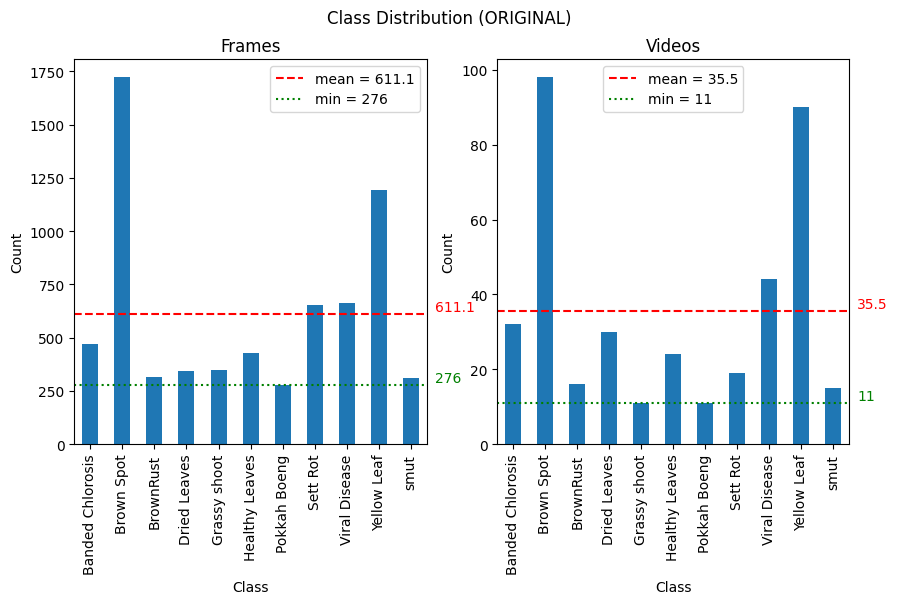

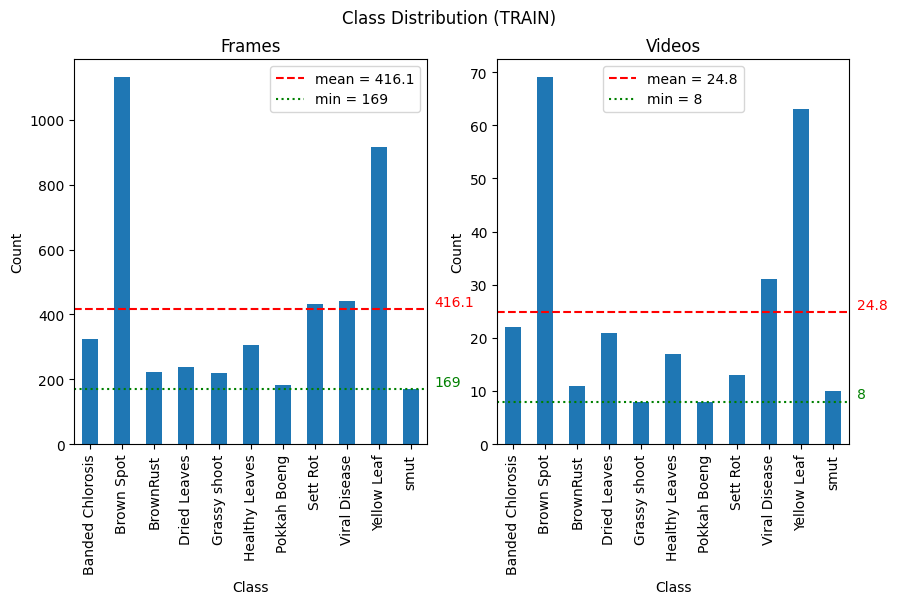

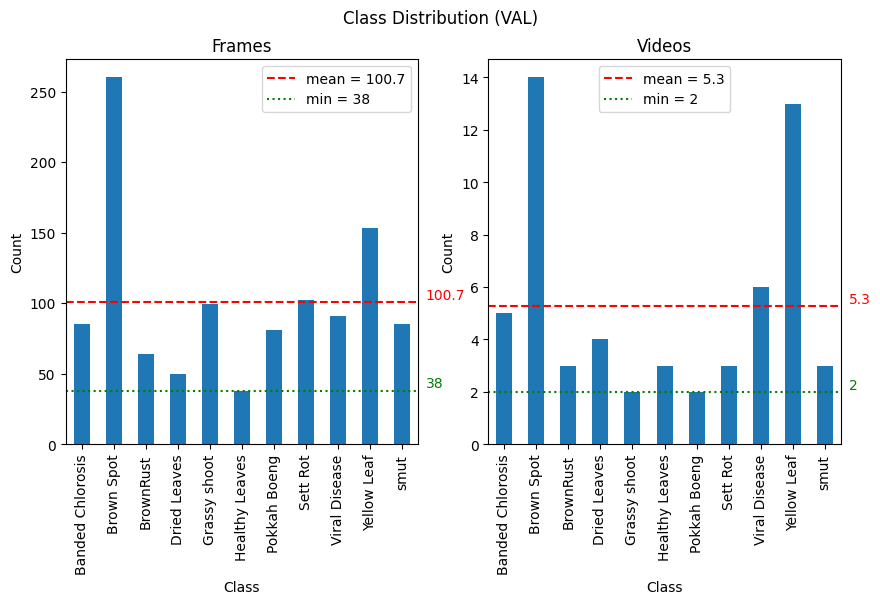

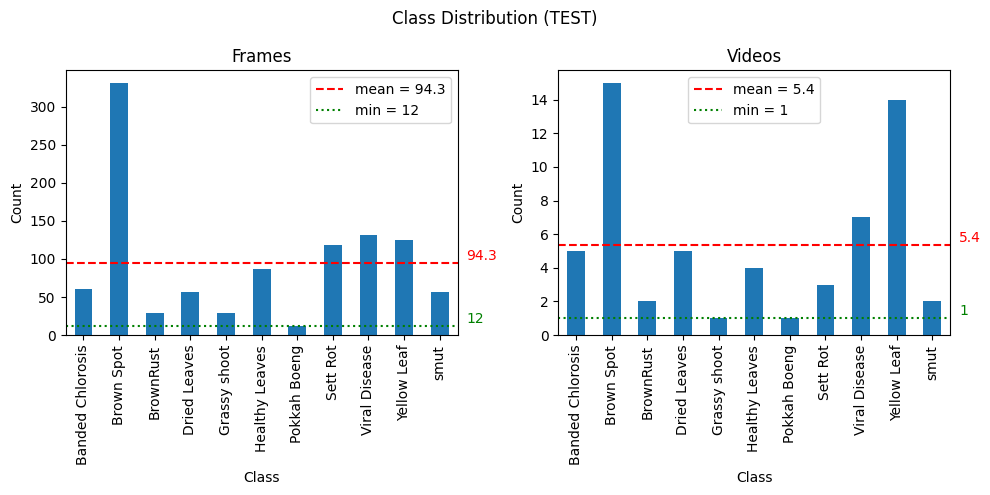

In [25]:
plot_images_distribution(df=df, include_context=False, title="Class Distribution (ORIGINAL)")
plot_images_distribution(df=train_df, include_context=False, title="Class Distribution (TRAIN)")
plot_images_distribution(df=val_df, include_context=False, title="Class Distribution (VAL)")
plot_images_distribution(df=test_df, include_context=False, title="Class Distribution (TEST)")

plt.tight_layout()
plt.show()

In [ ]:
import re

def copy_split_images(
    images_base_path: str,
    output_directory: str,
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame
):
    """
    Copy images from train, val, and test DataFrames into structured folders by split and class index.

    Directory structure:
        output_directory/train/<class_index>/<class_name_in_snake_case>_<image_id>.jpg

    Ensures no shared video_id across splits.
    """
    os.makedirs(output_directory, exist_ok=True)

    splits = {"train": train_df, "val": val_df, "test": test_df}


    # Map class names to numeric indices (sorted for consistency)
    class_to_idx = {
        cls: i for i, cls in enumerate(sorted(pd.concat(splits.values())["image_class"].unique()))
    }

    def to_snake_case(name: str) -> str:
        name = re.sub(r"[^0-9a-zA-Z]+", "_", name.strip())
        return name.lower().strip("_")

    for split_name, split_df in splits.items():
        split_dir = os.path.join(output_directory, split_name)
        os.makedirs(split_dir, exist_ok=True)

        for idx, row in split_df.iterrows():
            image_path = row["image_path"]
            image_class = str(row["image_class"])
            class_idx = class_to_idx[image_class]

            class_snake = to_snake_case(image_class)

            class_dir = os.path.join(split_dir, str(class_idx))
            os.makedirs(class_dir, exist_ok=True)

            src_path = os.path.join(images_base_path, image_path)
            dst_filename = f"{class_snake}_{idx}.jpg"
            dst_path = os.path.join(class_dir, dst_filename)

            if os.path.isfile(src_path):
                shutil.copy(src_path, dst_path)
            else:
                print(f"Warning: missing file {src_path}")

    print(f"✅ Copy complete. Classes mapped as:")
    for cls, idx in class_to_idx.items():
        print(f"  {idx}: {cls}")

copy_split_images(images_base_path=".DATA/SOURCE", output_directory=".DATA/DATASET", train_df=train_df, val_df=val_df, test_df=test_df)

✅ Copy complete. Classes mapped as:
  0: Banded Chlorosis
  1: Brown Spot
  2: BrownRust
  3: Dried Leaves
  4: Grassy shoot
  5: Healthy Leaves
  6: Pokkah Boeng
  7: Sett Rot
  8: Viral Disease
  9: Yellow Leaf
  10: smut
